# Tutorial 5a - NMR Spin Systems: Using Soprano to generate NMR spin systems and interface with simulation software


```
      _
    /|_|\   
   / / \ \  
  /_/   \_\  
  \ \   / /  
   \ \_/ /  
    \|_|/  

```
SOPRANO: a Python library for generation, manipulation and analysis of large batches of crystalline structures


*Developed within the CCP-NC project. Copyright STFC 2022*

In [1]:
# Basic imports
import os, sys
sys.path.insert(0, os.path.abspath('..')) # This to add the Soprano path to the PYTHONPATH
                                          # so we can load it without installing it

In [2]:
# Other useful imports

import numpy as np

from ase import io as ase_io
from ase.visualize.plot import plot_atoms

%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()

%reload_ext autoreload
%autoreload 2


## 1 - Preliminaries

For extraction of NMR-related propertied from .magres files, see the [05-nmr.ipynb](05-nmr.ipynb) tutorial. This tutorial will focus on the generation of NMR spin systems using Soprano and interfacing with simulation software.

In [3]:
C2H6O = ase_io.read('tutorial_data/ethanol.magres')
EDIZUM = ase_io.read('tutorial_data/EDIZUM.magres')

# We can do a nice trick with Soprano to connect 
# molecules across the periodic boundary (this only really
# works for organic molecular crystals):
from soprano.scripts.cli_utils import reload_as_molecular_crystal
C2H6O = reload_as_molecular_crystal(C2H6O)
EDIZUM = reload_as_molecular_crystal(EDIZUM)


## 2 - Selecting the subset

Often when exporting from a magres file to a spin system suitable for simulation, we are only interested in a subset of the spins. This can be achieved by creating a soprano selection object and passing it to the `get_spin_system` function. You can find more details on the selection methods in Soprano in [Tutorial 3](./03-atomselection_transforms.ipynb).

We will begin with some examples of useful selection approaches for spin systems.

In [4]:
from soprano.selection import AtomSelection

### 2.1 - Selecting by element, label, or index

If you only want a subset of spins based on a single element, you can use the `from_element` method. This will select all sites with the specified element.

```python
from soprano.selection import AtomSelection
# Only the Carbon atoms:
selC = AtomSelection.from_element(atoms, 'C')
```

Alternatively, you can use the `from_selection_string` method to select multiple elements at once. This method uses a string with the element symbols separated by commas.

```python
# Only the Carbon and Oxygen atoms:
selCO = AtomSelection.from_selection_string(atoms, 'C,O')
```

The `from_selection_string` method can also be used to select subsets based on their labels or indices. For example, to select the first and third carbon atoms:

```python
# Only the first and third Carbon atoms:
selC_1_3 = AtomSelection.from_selection_string(atoms, 'C.1,C.3')

# Only the sites labelled C1, H1a, H1b, and H1c:
selLabels = AtomSelection.from_selection_string(atoms, 'C1,H1a,H1b,H1c')
```


In [5]:


# 

Here's the whole structure with no selection:

(0.0, 25.0)

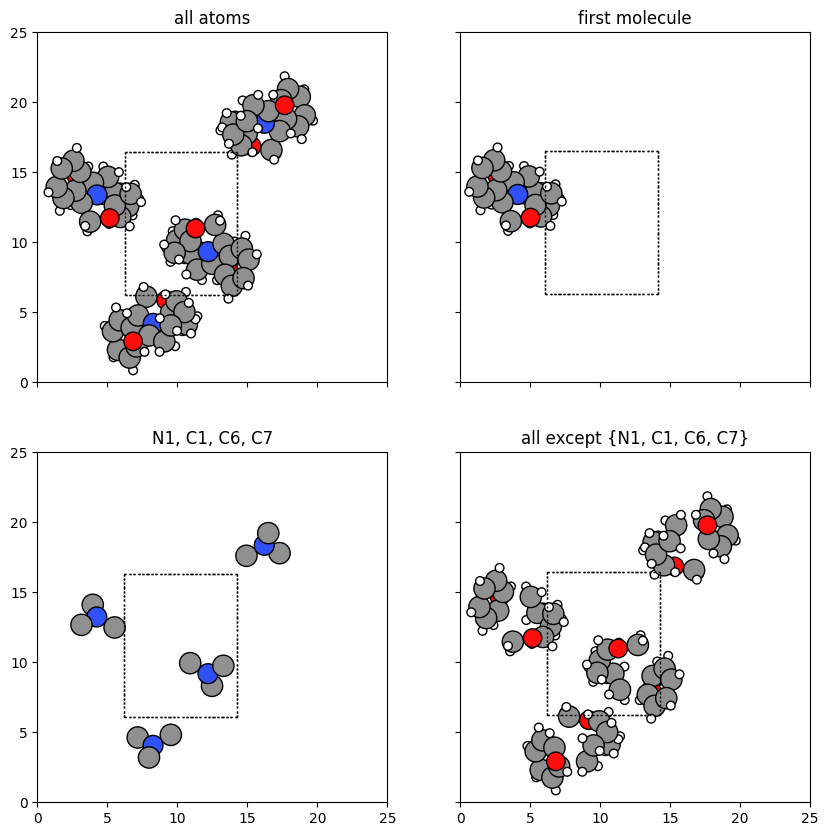

In [6]:
# Create a matplotlib figure with 4 subplots
fig, axarr = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax1, ax2, ax3, ax4 = axarr.flatten()

plot_atoms(EDIZUM, ax=ax1)
ax1.set_title('all atoms')

offset = (10,10)
# Only the first molecule
from soprano.properties.linkage import Molecules
molecules = Molecules.get(EDIZUM)
first_mol = molecules[0].subset(EDIZUM)

plot_atoms(first_mol, ax=ax2, offset=(0,6))
ax2.set_title('first molecule')


# Select the C1, C2, C3 and all H atoms:
sel = AtomSelection.from_selection_string(EDIZUM, 'N1,C1,C6,C7')
plot_atoms(sel.subset(EDIZUM), ax=ax3, offset=(2,2))
ax3.set_title('N1, C1, C6, C7')

# Select all atoms except the N1, C1, C6, C7:
sel_compl = AtomSelection.all(EDIZUM) - sel
plot_atoms(sel_compl.subset(EDIZUM), ax=ax4)
ax4.set_title('all except {N1, C1, C6, C7}')


ax1.set_xlim(0, 25)
ax1.set_ylim(0, 25)



And with the selection string: 'N1,C1,C6,C7'. Notice that there are four copies of that, corresponding to the four molecules in the unit cell.

### 2.2 - Selecting by distance

You can also select sites based on their distance from a reference site. This can be useful for selecting sites within a certain range of a defect site, for example. The `from_sphere` method takes a reference site and a distance in Angstroms.

```python
# All sites within 2.5 Angstroms of the first atom:
selDist = AtomSelection.from_sphere(atoms, atoms.positions[0], 2.5)
```


<Axes: >

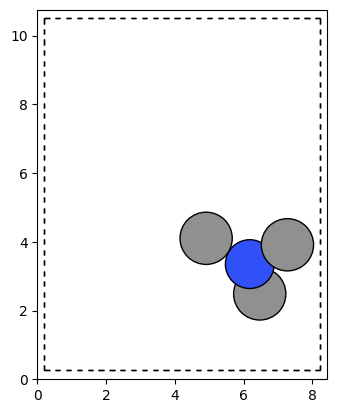

In [7]:
# One of the N atoms has index 138. Let's select all atoms within 2.0 Angstroms of it:
selDisc = AtomSelection.from_sphere(EDIZUM, EDIZUM.positions[138], 2.0)
plot_atoms(selDisc.subset(EDIZUM))

## 3 - Generating the spin system

In Soprano, a SpinSystem is made up of lists of Site and Coupling objects. Sites represent the individual spins in the system, and Couplings represent the interactions between them. As with other parts of Soprano, there is an AtomsProperty class that can be used to generate a SpinSystem from ase.Atoms objects. However, let's see how to create a SpinSystem from individual Site and Coupling objects first. See below for how to generate a SpinSystem from an Atoms object directly.

## 3.1 - Site

A Site is a single spin in the system. It has a label, isotope/species and (optionally) magnetic shielding and electric field gradient tensors. 

We can more conveniently create a list of site objects from an ase.Atoms object using the `get_sites` function. This function takes an ase.Atoms object and an AtomSelection object and returns a list of Site objects. 

In [8]:
from soprano.properties.nmr import get_sites
# Example selections:
selC13 = AtomSelection.from_selection_string(EDIZUM, 'C13')

# Extract the sites
sites = get_sites(EDIZUM, selection=selC13)

print(f"Extracted {len(sites)} sites")
# Print the first site
print(sites[0])

Extracted 4 sites
Site: C13 (isotope: 13C)
Magnetic Shielding Tensor for C:
[[137.77746,-16.47803, 92.94306],
 [-15.88779, 27.85678,-58.89048],
 [ 87.90102,-59.16857, 50.16629]]
HaeberlenShielding:
  sigma_iso (isotropy): 71.93351
  sigma (reduced anisotropy): 134.42515
  delta (anisotropy): 201.63772
  eta (asymmetry): 0.62167
Electric Field Gradient Tensor for 13C:
[[ 0.19059,-0.1067 , 0.26773],
 [-0.1067 ,-0.1589 ,-0.1102 ],
 [ 0.26773,-0.1102 ,-0.03169]]
Quadrupole moment: 0.0 barns
Nuclear spin: 0.5
This site is not quadrupole active.



### Manually creating a Site object

Sometimes we may want to create a Site object manually. This can be done by passing the label, isotope, and (optionally) the magnetic shielding and electric field gradient tensors. The tensors must be passed in as the relevant Soprano tensor object. 

For example:


In [9]:
from soprano.nmr import Site, MagneticShielding, ElectricFieldGradient
# Data for the Site
isotope = '2H'
label = 'H1a'
ms_data = np.array([
    [30.29817962,  1.20510693,  3.67274493],
    [ 1.96313295, 27.57652505,  2.57545224],
    [ 4.21834132,  2.16271308, 30.90315252]])
efg_data = np.array([
    [ 0.12793404,  0.05142987,  0.20226839],
    [ 0.05142987, -0.13353175,  0.04145601],
    [ 0.20226839,  0.04145601,  0.0055977 ]])

ms = MagneticShielding(ms_data, species = isotope)
efg = ElectricFieldGradient(efg_data, species=isotope)



# Create the Site object
site1 = Site(label=label, isotope=isotope, ms = ms, efg = efg)
# Printing a Site object will give a nice summary of the data
print(site1)

# We can also create a Site object from a dictionary:
site2 = Site.from_dict({
    'label': 'H1a',
    'isotope': '2H',
    'ms': {
        'data': ms_data,
        'species': '2H'
    },
    'efg': {
        'data': efg_data,
        'species': '2H'
    }
})


Site: H1a (isotope: 2H)
Magnetic Shielding Tensor for 2H:
[[30.29818, 1.20511, 3.67274],
 [ 1.96313,27.57653, 2.57545],
 [ 4.21834, 2.16271,30.90315]]
HaeberlenShielding:
  sigma_iso (isotropy): 29.59262
  sigma (reduced anisotropy): 5.96101
  delta (anisotropy): 8.94151
  eta (asymmetry): 0.14197
Electric Field Gradient Tensor for 2H:
[[ 0.12793, 0.05143, 0.20227],
 [ 0.05143,-0.13353, 0.04146],
 [ 0.20227, 0.04146, 0.0056 ]]
Quadrupole moment: 2.86 barns
Nuclear spin: 1.0
Quadrupolar constant: 193809.11989799573 Hz
Quadrupolar product: 193819.8155077332 Hz
Quadrupolar frequency: 290713.6798469936 Hz



In [10]:
site2

Site(label='H1a', isotope='2H', efg=NMRTensor(data=[[ 0.12793404  0.05142987  0.20226839]
 [ 0.05142987 -0.13353175  0.04145601]
 [ 0.20226839  0.04145601  0.0055977 ]]), ms=NMRTensor(data=[[30.29817962  1.20510693  3.67274493]
 [ 1.96313295 27.57652505  2.57545224]
 [ 4.21834132  2.16271308 30.90315252]]))

## 3.2 - Couplings

A Coupling is an interaction between two sites. It has a label, a list of site indices it connects, and the coupling tensor. 

There are two types of Coupling implemented in Soprano: DipolarCoupling and ISCoupling. The DipolarCoupling class represents the dipolar interaction between two sites, and the ISCoupling class represents the spin-spin or J-coupling. 



### 3.2.1 - Dipolar Coupling

As with the sites, we can generate a list of couplings from an ase.Atoms object using the `get_dipolar_couplings` function. This function takes an ase.Atoms object and (optionally) an AtomSelection object and returns a list of Coupling objects.

In [11]:
from soprano.properties.nmr import get_dipolar_couplings
# Example selections:
selC13 = AtomSelection.from_selection_string(EDIZUM, 'C13')
selC14 = AtomSelection.from_selection_string(EDIZUM, 'C14')

# Extract the dipolar couplings
dcouplings = get_dipolar_couplings(EDIZUM, sel_i = selC13, sel_j = selC14)

# Print the dipolar couplings
print(f"Extracted {len(dcouplings)} dipolar couplings")
print("  i - j\t dipolar couplings (Hz)")
for d in dcouplings:
    print(f"{d.site_i} - {d.site_j}: {d.coupling_constant:10.2f}")

Extracted 16 dipolar couplings
  i - j	 dipolar couplings (Hz)
124 - 130:     -10.01
127 - 129:     -10.01
126 - 130:   -2912.52
125 - 131:     -10.01
124 - 129:    -118.62
125 - 128:    -118.62
127 - 131:   -2912.52
126 - 129:     -13.89
127 - 128:     -13.89
124 - 131:     -13.89
126 - 128:     -10.01
125 - 130:     -13.89
124 - 128:   -2912.52
126 - 131:    -118.62
127 - 130:    -118.62
125 - 129:   -2912.52


Another example is if we have multiple molecules in the unit cell and want just intramolecule couplings. We can use the `Molecules` class to get the molecules and then use the `get_dipolar_couplings` function on the molecule subset. For example, to get the dipolar couplings for the first molecule in the unit cell:


In [12]:
# Selecting the atoms in the first molecule:
from soprano.properties.linkage import Molecules
molecules = Molecules.get(EDIZUM)
first_mol = molecules[0].subset(EDIZUM, use_cell_indices=True)


# Let's say we just want the coupling between H14 and C9:
sel_i = AtomSelection.from_selection_string(first_mol, 'H14')
sel_j = AtomSelection.from_selection_string(first_mol, 'C9')
# we can specify the isotopes for the atoms
isotopes = {'H': 2, 'C': 13}
first_mol_dipolar = get_dipolar_couplings(first_mol, sel_i, sel_j, isotopes=isotopes)

print(f"Number of couplings: {len(first_mol_dipolar)}")
print("Site_i Site_j Coupling (Hz)")
for d in first_mol_dipolar:
    # print(d.site_i, d.site_j, d.coupling_constant)
    # Format neatly i,j and the coupling constant
    print(f"{d.site_i:5d} {d.site_j:5d} {d.coupling_constant:10.3f}")

Number of couplings: 1
Site_i Site_j Coupling (Hz)
    5    13  -4932.655


```{note}
Note that the indices are always relative to the atoms object you're dealing with, so in this case we created a new atoms object that was a subset of the original one, and the indices are relative to that new object.
```

#### Manually specifying dipolar couplings

The `get_dipolar_couplings` function is a wrapper function around the `AtomsProperty` called `DipolarCouplingList`. You can use this directly, as with other AtomsProperties (see [Tutorial 2](02-generators_properties_calculators.ipynb) for information on how these work in Soprano).


If instead you work with data from other sources or need more control over the dipolar couplings, you can create the DipolarCoupling objects manually as in the below example.

In [13]:
from soprano.nmr.coupling import DipolarCoupling
from soprano.nmr import NMRTensor

dipolar_data = np.array([-2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]).reshape(3, 3)
coupling = DipolarCoupling(
    site_i=1,
    site_j=2,
    species1='1H',
    species2='13C',
    tensor=NMRTensor(dipolar_data, order='n'),
    tag='test_tag',
)

# Show the representation of the coupling
coupling

DipolarCoupling(site_i=1, site_j=2, species1='1H', species2='13C', tensor=NMRTensor(data=[[-2.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]), type='D', tag='test_tag', gamma1=267522128.0, gamma2=67282840.0)

### 3.3 - SpinSystem

Now that we've covered sites and couplings, we can finally construct a SpinSystem.

We again can use a utility function to generate a SpinSystem from an ase.Atoms object. The `get_spin_system` function takes an ASE `Atoms` object and (optionally) an AtomSelection object and returns a SpinSystem object. Or we can create a SpinSystem manually by passing lists of Site and Coupling objects - that way we have more control over which sites and couplings are included in the spin system.

In [14]:
from soprano.properties.nmr import get_spin_system
# Select first three H atoms - the methyl group:
references = {'H': 30.0, 'C': 170.0, 'O': 200.0}
isotopes = {'H': 1, 'C': 13, 'O': 17}
spin_system = get_spin_system(C2H6O[:3], isotopes=isotopes, include_dipolar=True, references=references)

<Axes: >

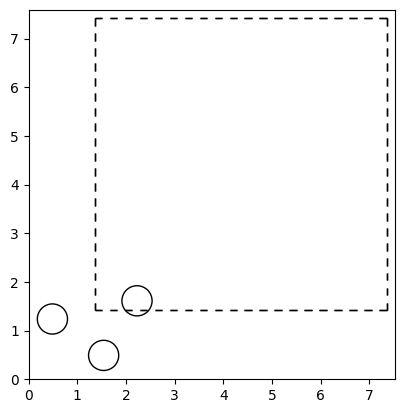

In [15]:
plot_atoms(C2H6O[:3])

In [16]:
spin_system.get_couplings(0, 1)

[DipolarCoupling(site_i=0, site_j=1, species1='1H', species2='1H', tensor=NMRTensor(data=[[ -1343.72451394  16356.76737704 -26455.59151433]
  [ 16356.76737704  10060.85885201  18794.21384093]
  [-26455.59151433  18794.21384093  -8717.13433807]]), type='D', tag=None, gamma1=267522128.0, gamma2=267522128.0)]

In [17]:
spin_system.to_mrsimulator()

{'sites': [{'isotope': '1H',
   'label': 'H',
   'isotropic_chemical_shift': 0.4073931626948822,
   'shielding_symmetric': {'zeta': -8.9415148312736,
    'eta': 0.14196800078113322,
    'alpha': 0.48803517894526216,
    'beta': 0.7913150929573427,
    'gamma': 0.4683872043686721}},
  {'isotope': '1H',
   'label': 'H',
   'isotropic_chemical_shift': -0.25605869019403743,
   'shielding_symmetric': {'zeta': -8.18850823038747,
    'eta': 0.21082029526274973,
    'alpha': 4.758887283431449,
    'beta': 1.3503402102084974,
    'gamma': 1.6270867160340883}},
  {'isotope': '1H',
   'label': 'H',
   'isotropic_chemical_shift': -0.10275656683033554,
   'shielding_symmetric': {'zeta': -7.287596537087886,
    'eta': 0.06045150406398976,
    'alpha': 3.1772616059622467,
    'beta': 0.6133956106610516,
    'gamma': 2.9051980259777777}}],
 'couplings': [{'dipolar': {'D': -21680.806327541308,
    'alpha': 5.665509465554392,
    'beta': 0.818065770286876,
    'gamma': 0.0},
   'site_index': [0, 1]},
  